In [1]:
# Importing the relevant libraries
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random


#Sklearn package
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score


import re
from functools import reduce

#NLP packages using Spacy
import string
import spacy
from spacy import displacy

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import gensim 
from gensim.models import Word2Vec 
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Explainer package
from lime.lime_text import LimeTextExplainer  # from the paper

# Path package
from pathlib import Path

In [2]:
# import data
df = pd.read_csv(
    '../../events/group_all_labelled_with_sentiment.csv', usecols=['event_text', 'Near Miss Event', 'polarity', 'subjectivity', 'negative', 'neutral','positive', 'compound'])


In [3]:
df.head()


,event_text,Near Miss Event,polarity,subjectivity,negative,neutral,positive,compound
0,following the completion of the hole and loggi...,False,0.000000,0.550000,0.056,0.944,0.000,-0.3182
1,mineral drillholes data 2. lithology summary a...,False,0.316667,0.500000,0.000,0.963,0.037,0.2263
2,several suitable target areas were identified ...,False,0.325000,0.395833,0.000,0.948,0.052,0.5106
3,the gascoyne platform is a diamond shaped area...,False,-0.200000,0.800000,0.000,0.967,0.033,0.3400
4,bromine levels in the halite are high (up to 3...,True,0.094375,0.374375,0.035,0.944,0.022,-0.0772


# Spacy

In [4]:
# spacy
nlp = spacy.load("en_core_web_lg")
        
# Creating our tokenizer function
# https://towardsdatascience.com/building-a-topic-modeling-pipeline-with-spacy-and-gensim-c5dc03ffc619
def lemmatizer(doc):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_.lower().strip() for token in doc if token.lemma_ != '-PRON-']
    doc = u' '.join(doc)
    return nlp.make_doc(doc)
    
def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
    return doc

# create our language pipeline
nlp = spacy.load("en_core_web_lg")
nlp.add_pipe(lemmatizer,name='lemmatizer')  # lemmatizer
nlp.add_pipe(remove_stopwords, name="stopwords", last=True)  # remove stopwords + punctuation, return textt

In [5]:
df['tokens'] = list(nlp.pipe(df.event_text.values, batch_size=100))  # adjust
df['clean_text'] = df['tokens'].map(lambda tokens: " ".join(tokens))
df.head()

,event_text,Near Miss Event,polarity,subjectivity,negative,neutral,positive,compound,tokens,clean_text
0,following the completion of the hole and loggi...,False,0.000000,0.550000,0.056,0.944,0.000,-0.3182,"[follow, completion, hole, logging, core, lack...",follow completion hole logging core lack evapo...
1,mineral drillholes data 2. lithology summary a...,False,0.316667,0.500000,0.000,0.963,0.037,0.2263,"[mineral, drillholes, data, 2, lithology, summ...",mineral drillholes data 2 lithology summary ap...
2,several suitable target areas were identified ...,False,0.325000,0.395833,0.000,0.948,0.052,0.5106,"[suitable, target, area, identify, area, apply...",suitable target area identify area apply explo...
3,the gascoyne platform is a diamond shaped area...,False,-0.200000,0.800000,0.000,0.967,0.033,0.3400,"[gascoyne, platform, diamond, shape, area, cov...","gascoyne platform diamond shape area cover 86,..."
4,bromine levels in the halite are high (up to 3...,True,0.094375,0.374375,0.035,0.944,0.022,-0.0772,"[bromine, level, halite, high, 330ppm, suggest...",bromine level halite high 330ppm suggest preci...


# Vectorization using Doc2Vec 

In [6]:
# train model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from datetime import datetime

def get_doc2vec(model, df):
    vecs = []
    for idx in df.index:
        try:
            vec = model.docvecs[idx]
        except:
            vec = np.nan
        vecs.append(vec)
    return vecs

model_path = 'doc2vec.model'

# Storing the question texts in a list
event_texts = df.clean_text.tolist()

# Creating a list of terms and a list of labels to go with it
documents = [TaggedDocument(doc, tags=[str(i)]) for i, doc in enumerate(event_texts)]
print(f'Doc2Vec model training on {len(df)} reports starting at {datetime.now().time()}')

max_epochs = 100

#with Timer():
    #Note: dm defines the training algorithm.
    # If dm=1 means ‘distributed memory’ (PV-DM) and dm =0 means ‘distributed bag of words’ (PV-DBOW).
model = Doc2Vec(vector_size=50, alpha=0.025, min_alpha=0.00025, min_count=2, dm=1, epochs=max_epochs, workers=4)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

Doc2Vec model training on 1671 reports starting at 11:28:57.033193


In [7]:
model.save(model_path)

In [8]:
# Event Text Vector
df['event_text_vector'] = get_doc2vec(model,df)


In [9]:
vector_df = pd.DataFrame(df.event_text_vector.tolist(), index=df.index)
df = df.join(vector_df)


# Classification

In [10]:
X = df.drop(columns = [ 'event_text', "Near Miss Event", 'tokens', 'clean_text', 'event_text_vector'])
y = df['Near Miss Event'].astype(int)
X

,polarity,subjectivity,negative,neutral,positive,compound,0,1,2,3,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.550000,0.056,0.944,0.000,-0.3182,-0.103373,-0.366715,0.408298,0.397378,...,1.211946,-0.776295,0.196526,-0.354041,0.335938,0.330970,-0.365367,0.806155,1.201803,-1.333079
1,0.316667,0.500000,0.000,0.963,0.037,0.2263,-0.277914,0.169007,-0.459560,0.073816,...,-0.849995,-0.107888,-2.138740,-0.524076,0.063736,0.453261,-0.105093,-1.233652,-0.475173,-0.832960
2,0.325000,0.395833,0.000,0.948,0.052,0.5106,-0.498937,-0.479393,-0.624705,-1.296647,...,0.938427,0.104232,-1.576976,0.246382,-0.429574,-0.083280,-0.693847,-0.856457,-0.849183,-0.369180
3,-0.200000,0.800000,0.000,0.967,0.033,0.3400,-0.259438,-0.380350,-0.335608,-1.789649,...,0.188800,0.086011,0.244154,-0.694117,0.279008,0.105071,-1.094029,-0.135715,-0.134076,-0.552000
4,0.094375,0.374375,0.035,0.944,0.022,-0.0772,0.470306,-0.435517,-0.422206,0.613519,...,2.352959,-0.085784,-1.840706,1.109179,0.960462,-0.207253,0.644868,0.500211,-0.463527,-1.961772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,-0.104762,0.384524,0.019,0.882,0.099,0.9565,0.822304,-0.640235,0.691730,0.772735,...,1.871317,-0.430315,-0.153924,-0.142183,-1.402396,0.803567,0.852766,1.160597,0.548710,-0.946366
1667,0.007981,0.559519,0.012,0.887,0.100,0.9201,0.352134,-0.130792,-0.176124,0.167115,...,1.534692,0.087348,-1.311971,0.610350,0.727905,-0.505326,-0.236086,0.884134,0.535042,-1.064816
1668,0.012500,0.545000,0.032,0.897,0.071,0.6369,1.149105,-1.105115,-0.367566,-0.461295,...,-1.135228,0.061274,0.529722,0.976734,-1.089486,0.133418,-0.629462,-0.513172,0.175905,0.695333
1669,0.080000,0.420000,0.025,0.954,0.021,-0.0772,-1.276079,-0.660720,0.140428,-0.560911,...,-0.072409,-0.461097,0.193096,0.510829,-0.229816,1.418313,-0.921486,0.164140,-0.161051,-0.980358


In [11]:
#Split train/test set
random.seed(4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(f'Class balance for train set:\n{y_train.value_counts()}\n')
print(f'Class balance for test set:\n{y_test.value_counts()}')

(1169, 56) (502, 56) (1169,) (502,)
Class balance for train set:
0    880
1    289
Name: Near Miss Event, dtype: int64

Class balance for test set:
0    366
1    136
Name: Near Miss Event, dtype: int64


# LazyPredict

In [12]:
import lazypredict
from lazypredict.Supervised import LazyClassifier
Lazy_clf = LazyClassifier()
models, predictions = Lazy_clf.fit(X_train, X_test, y_train, y_test)
models


C:\Users\lykvu\.conda\envs\CITS5508\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.58it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
DecisionTreeClassifier,0.65,0.56,0.56,0.65,0.09
LabelPropagation,0.71,0.55,0.55,0.67,0.14
LabelSpreading,0.71,0.55,0.55,0.67,0.15
LGBMClassifier,0.73,0.55,0.55,0.67,0.16
SGDClassifier,0.67,0.54,0.54,0.65,0.04
XGBClassifier,0.72,0.53,0.53,0.66,0.28
ExtraTreeClassifier,0.67,0.53,0.53,0.65,0.02
GaussianNB,0.68,0.53,0.53,0.65,0.02
NearestCentroid,0.57,0.53,0.53,0.59,0.02


# Logistic Regression

In [13]:
# Logistic Regression Classifier
LR_clf = LogisticRegression()

# model generation
LR_clf.fit(X_train, y_train)

LogisticRegression()

In [14]:
# Predicting with a test dataset
LR_predictions = LR_clf.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, LR_predictions))
print("Logistic Regression Precision:",metrics.precision_score(y_test, LR_predictions))
print("Logistic Regression Recall:",metrics.recall_score(y_test, LR_predictions))
print("Logistic Regression ROC AUC:",roc_auc_score(y_test, LR_predictions))
print("\n Classification report:\n", classification_report(y_test, LR_predictions))

Logistic Regression Accuracy: 0.7171314741035857
Logistic Regression Precision: 0.38461538461538464
Logistic Regression Recall: 0.07352941176470588
Logistic Regression ROC AUC: 0.5149067823850851

 Classification report:
               precision    recall  f1-score   support

           0       0.74      0.96      0.83       366
           1       0.38      0.07      0.12       136

    accuracy                           0.72       502
   macro avg       0.56      0.51      0.48       502
weighted avg       0.64      0.72      0.64       502



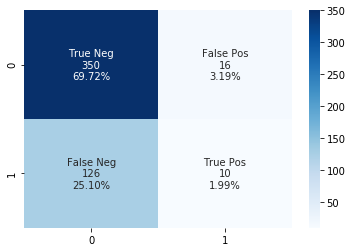

In [15]:
LR_cm = confusion_matrix(y_test, LR_predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in LR_cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     LR_cm.flatten()/np.sum(LR_cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(LR_cm, annot=labels, fmt='', cmap='Blues')

# SVM

# GridSearch CV

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [17]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(class_weight = 'balanced'),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.1s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.1s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   0.1s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] .

[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=1, gamma=0.001, kernel=sigmoid ................................
[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   0.1s
[CV] C=10, gamma=1, kernel=poly ......................................
[CV] .

[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   0.1s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .

[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   0.1s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   17.5s finished


GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [18]:
print(grid.best_estimator_)

SVC(C=100, class_weight='balanced', gamma=0.1)


In [19]:
# Predicting with a test dataset
grid_predictions = grid.predict(X_test)
#Model performance 
print(confusion_matrix(y_test,grid_predictions))
print("Accuracy:",metrics.accuracy_score(y_test, grid_predictions)), print("Precision:",metrics.precision_score(y_test, grid_predictions))
print("Recall:",metrics.recall_score(y_test, grid_predictions))
print("ROC AUC:",roc_auc_score(y_test, grid_predictions))
print(classification_report(y_test,grid_predictions))

[[348  18]
 [121  15]]
Accuracy: 0.7231075697211156
Precision: 0.45454545454545453
Recall: 0.11029411764705882
ROC AUC: 0.5305568948891031
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       366
           1       0.45      0.11      0.18       136

    accuracy                           0.72       502
   macro avg       0.60      0.53      0.51       502
weighted avg       0.66      0.72      0.66       502



# SVM with different Kernels 

In [20]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto", class_weight = 'balanced')
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto",class_weight = 'balanced')
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto", class_weight = 'balanced')
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto",class_weight = 'balanced' )

In [21]:
for i in range(4):
   # Train a SVC model using different kernal
    svclassifier = getClassifier(i) 
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(confusion_matrix(y_test,y_pred))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("ROC AUC:",roc_auc_score(y_test, y_pred))
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
[[366   0]
 [134   2]]
Accuracy: 0.7330677290836654
Precision: 1.0
Recall: 0.014705882352941176
ROC AUC: 0.5073529411764706
              precision    recall  f1-score   support

           0       0.73      1.00      0.85       366
           1       1.00      0.01      0.03       136

    accuracy                           0.73       502
   macro avg       0.87      0.51      0.44       502
weighted avg       0.80      0.73      0.62       502

Evaluation: RBF kernel
[[230 136]
 [ 78  58]]
Accuracy: 0.5737051792828686
Precision: 0.29896907216494845
Recall: 0.4264705882352941
ROC AUC: 0.5274429443908711
              precision    recall  f1-score   support

           0       0.75      0.63      0.68       366
           1       0.30      0.43      0.35       136

    accuracy                           0.57       502
   macro avg       0.52      0.53      0.52       502
weighted avg       0.63      0.57      0.59       502

Evaluation: Sigmoid kernel
[[22

# Prediction with the best SVM parameters 

In [22]:
#Fit SVM model with best chosen parameters
SVM_clf = SVC(kernel='linear', gamma="auto",class_weight = 'balanced' )
SVM_clf.fit(X_train, y_train)# Make prediction
SVM_y_pred = SVM_clf.predict(X_test)# Evaluate our model


In [23]:
# Model performance
print("Accuracy:",metrics.accuracy_score(y_test, SVM_y_pred))
print("Precision:",metrics.precision_score(y_test, SVM_y_pred))
print("Recall:",metrics.recall_score(y_test, SVM_y_pred))
print("ROC AUC:",roc_auc_score(y_test, SVM_y_pred))
print(classification_report(y_test,SVM_y_pred))

Accuracy: 0.5956175298804781
Precision: 0.3456221198156682
Recall: 0.5514705882352942
ROC AUC: 0.5817462230793957
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       366
           1       0.35      0.55      0.42       136

    accuracy                           0.60       502
   macro avg       0.57      0.58      0.56       502
weighted avg       0.67      0.60      0.62       502



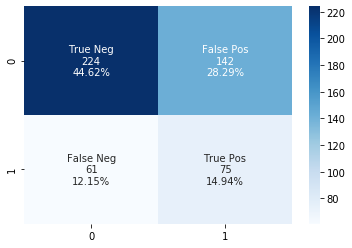

In [24]:
SVM_cm = confusion_matrix(y_test, SVM_y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in SVM_cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     SVM_cm.flatten()/np.sum(SVM_cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(SVM_cm, annot=labels, fmt='', cmap='Blues')

# Imbalance dataset classification with SMOTE

Source: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [25]:

# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7,8]
for k in k_values:
	# define pipeline
	model = DecisionTreeClassifier()
	over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy=0.5)
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.829
> k=2, Mean ROC AUC: 0.830
> k=3, Mean ROC AUC: 0.838
> k=4, Mean ROC AUC: 0.838
> k=5, Mean ROC AUC: 0.850
> k=6, Mean ROC AUC: 0.841
> k=7, Mean ROC AUC: 0.840
> k=8, Mean ROC AUC: 0.856


In [26]:

# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
	# define pipeline
	model = SVC()
	over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy=0.5)
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.944
> k=2, Mean ROC AUC: 0.941
> k=3, Mean ROC AUC: 0.937
> k=4, Mean ROC AUC: 0.938
> k=5, Mean ROC AUC: 0.932
> k=6, Mean ROC AUC: 0.936
> k=7, Mean ROC AUC: 0.934


In [27]:

# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# values to evaluate
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    # define pipeline
    model = SVC(kernel = 'poly', probability=True)
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

> k=1, Mean ROC AUC: 0.949
> k=2, Mean ROC AUC: 0.952
> k=3, Mean ROC AUC: 0.953
> k=4, Mean ROC AUC: 0.952
> k=5, Mean ROC AUC: 0.952
> k=6, Mean ROC AUC: 0.952
> k=7, Mean ROC AUC: 0.950


In [28]:
pipeline.fit(X,y)

Pipeline(steps=[('over', SMOTE(k_neighbors=7, sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('model', SVC(kernel='poly', probability=True))])

In [29]:
y_pred = pipeline.predict(X)

print("Accuracy:",metrics.accuracy_score(y, y_pred))
print("Precision:",metrics.precision_score(y, y_pred))
print("Recall:",metrics.recall_score(y, y_pred))
print("ROC AUC:",roc_auc_score(y, y_pred))
print(classification_report(y,y_pred))
print(confusion_matrix(y,y_pred))

Accuracy: 0.9775
Precision: 0.2837370242214533
Recall: 0.82
ROC AUC: 0.8995454545454545
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9900
           1       0.28      0.82      0.42       100

    accuracy                           0.98     10000
   macro avg       0.64      0.90      0.71     10000
weighted avg       0.99      0.98      0.98     10000

[[9693  207]
 [  18   82]]


In [30]:
pipeline.predict_proba(X)

array([[9.15552947e-01, 8.44470530e-02],
       [9.52505936e-01, 4.74940640e-02],
       [9.28425036e-01, 7.15749644e-02],
       ...,
       [9.98034294e-01, 1.96570643e-03],
       [9.99948910e-01, 5.10902224e-05],
       [9.48807812e-01, 5.11921876e-02]])

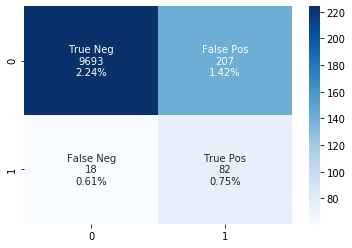

In [31]:
sample_cm = confusion_matrix(y, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in sample_cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     SVM_cm.flatten()/np.sum(sample_cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(SVM_cm, annot=labels, fmt='', cmap='Blues')